![terrainbento logo](../images/terrainbento_logo.png)

# terrainbento model BasicCh steady-state solution

This model shows example usage of the BasicCh model from the TerrainBento package.

Instead of the linear flux law for hillslope erosion and transport, BasicCh uses a nonlinear hillslope sediment flux law:

$\frac{\partial \eta}{\partial t} = - KQ^{1/2}S - \nabla q_h$ 

$q_h = -DS \left[ 1 + \left( \frac{S}{S_c} \right)^2 +  \left( \frac{S}{S_c} \right)^4 + ... \left( \frac{S}{S_c} \right)^{2(N-1)} \right]$

where $Q$ is the local stream discharge, $S$ is the local slope, $K$ is the erodability by water, $D$ is the regolith transport efficiency, and $S_c$ is the critical slope. $q_h$ represents the hillslope sediment flux per unit width. $N$ is the number of terms in the Taylor Series expansion.
    
Refer to [Barnhart et al. (2019)](https://www.geosci-model-dev-discuss.net/gmd-2018-204/) for further explaination. For detailed information about creating a BasicCh model, see [the detailed documentation](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.derived_models.model_basicCh.html).

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"font.size": 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import BasicCh

np.random.seed(42)

In [2]:
# create the parameter dictionary needed to instantiate the model 

params = {
    # create the Clock.
    "clock": {"start": 0, 
              "step": 10,
              "stop": 1e7},
    
    # Create the Grid.
    "grid": {"grid": {"RasterModelGrid":[(100, 160), {"xy_spacing": 10}]},
             "fields": {"at_node": {"topographic__elevation":{"random":[{"where":"CORE_NODE"}]}}}},
    
    # Set up Boundary Handlers
    "boundary_handlers":{"NotCoreNodeBaselevelHandler": {"modify_core_nodes": True, 
                                                         "lowering_rate": -0.001}},
    # Parameters that control output.
    "output_interval": 1e4, 
    "save_first_timestep": True,
    "output_prefix": "output_netcdfs/basicCh.",
    "fields":["topographic__elevation"],
             
    # Parameters that control process and rates.
    "water_erodability" : 0.001,
    "m_sp" : 0.5,
    "n_sp" : 1.0, 
    "regolith_transport_parameter" : 0.2,           
    "critical_slope" : 0.07, # unitless
    }

In [3]:
# we can use an output writer to run until the model reaches steady state. 
class run_to_steady(object):
    def __init__(self, model):
        self.model = model
        self.last_z = self.model.z.copy()
        self.tolerance = 0.00001
    def run_one_step(self):
        if model.model_time > 0:
            diff = (self.model.z[model.grid.core_nodes]
                    - self.last_z[model.grid.core_nodes])
            if max(abs(diff)) <= self.tolerance: 
                self.model.clock.stop = model._model_time
                print("Model reached steady state in " + str(model._model_time) + " time units\n")
            else:
                self.last_z = self.model.z.copy()
                if model._model_time <= self.model.clock.stop - self.model.output_interval:
                    self.model.clock.stop += self.model.output_interval

In [4]:
# initialize the model using the Model.from_dict() constructor. 
# We also pass the output writer here. 
model = BasicCh.from_dict(params, output_writers={"class": [run_to_steady]})

# to run the model as specified, we execute the following line:
model.run()

Model reached steady state in 260000.0 time units



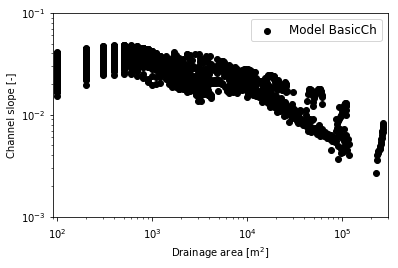

In [5]:
# MAKE SLOPE-AREA PLOT

# plot nodes that are not on the boundary or adjacent to it
core_not_boundary = np.array(model.grid.node_has_boundary_neighbor(model.grid.core_nodes)) == False
plotting_nodes = model.grid.core_nodes[core_not_boundary]

# assign area_array and slope_array
area_array = model.grid.at_node["drainage_area"][plotting_nodes]
slope_array = model.grid.at_node["topographic__steepest_slope"][plotting_nodes]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

# plot the data
slope_area.scatter(area_array, slope_array, marker="o", c="k", 
                   label = "Model BasicCh") 
                   
# make axes log and set limits
slope_area.set_xscale("log")
slope_area.set_yscale("log")

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-3, 1e-1)

# set x and y labels
slope_area.set_xlabel(r"Drainage area [m$^2$]")
slope_area.set_ylabel("Channel slope [-]")
slope_area.legend(scatterpoints=1,prop={"size":12})
slope_area.tick_params(axis="x", which="major", pad=7)

# save out an output figure
output_figure = os.path.join("output_figures/maintext_taylor_hillslopes_slope_area.eps")
fig.savefig(output_figure, bbox_inches="tight", dpi=1000) # save figure

In [6]:
# Save stack of all netcdfs for Paraview to use.
model.save_to_xarray_dataset(filename="output_netcdfs/basicCh.nc", 
                             time_unit="years", 
                             reference_time="model start", 
                             space_unit="meters")
        
# remove temporary netcdfs
model.remove_output_netcdfs()

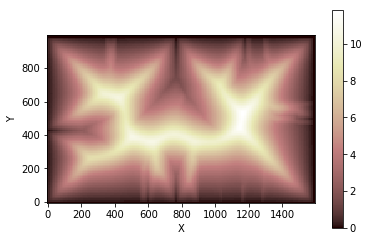

In [7]:
# make a plot of the final steady state topography
imshow_grid(model.grid, "topographic__elevation")

## Next Steps

- We recommend you review the [terrainbento manuscript](https://www.geosci-model-dev-discuss.net/gmd-2018-204/).

- There are three additional introductory tutorials: 

    1) [Introduction terrainbento](http://localhost:8888/notebooks/example_usage/Introduction_to_terrainbento.ipynb) 
    
    2) [Introduction to boundary conditions in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb)
    
    3) [Introduction to output writers in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_output_writers.ipynb). 
    
    
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:

    1) [Basic](http://localhost:8888/notebooks/coupled_process_elements/model_basic_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

    2) [BasicVm](http://localhost:8888/notebooks/coupled_process_elements/model_basic_var_m_steady_solution.ipynb) which permits the drainage area exponent to change

    3) **This Notebook**: [BasicCh](http://localhost:8888/notebooks/coupled_process_elements/model_basicCh_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law

    4) [BasicVs](http://localhost:8888/notebooks/coupled_process_elements/model_basicVs_steady_solution.ipynb) which uses variable source area hydrology

    5) [BasisRt](http://localhost:8888/notebooks/coupled_process_elements/model_basicRt_steady_solution.ipynb) which allows for two lithologies with different K values